In [178]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import altair as alt 
import xlrd 
import sys 
np.set_printoptions(threshold=sys.maxsize)
pd.options.mode.chained_assignment = None  # default='warning'

import sklearn 
import seaborn as sns 

In [179]:
referendum_dataset = pd.read_csv("/Users/sebastienlouis/rnd-explo/SaintGobain/Referendum.csv", sep=";")

In [180]:
referendum_dataset

,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Inscrits,Abstentions,Blancs et nuls,Choix A,Choix B
0,1,AIN,1,L'Abergement-Clémenciat,592,84,9,154,345
1,1,AIN,2,L'Abergement-de-Varey,215,36,5,66,108
2,1,AIN,4,Ambérieu-en-Bugey,8205,1698,126,2717,3664
3,1,AIN,5,Ambérieux-en-Dombes,1152,170,18,280,684
4,1,AIN,6,Ambléon,105,17,1,35,52
...,...,...,...,...,...,...,...,...,...
36786,ZZ,FRANCAIS DE L'ETRANGER,7,Europe centrale,89643,54981,318,17055,17289
36787,ZZ,FRANCAIS DE L'ETRANGER,8,"Europe du Sud, Turquie, Israël",109763,84466,292,9299,15706
36788,ZZ,FRANCAIS DE L'ETRANGER,9,Afrique Nord-Ouest,98997,59887,321,22116,16673
36789,ZZ,FRANCAIS DE L'ETRANGER,10,"Afrique Centre, Sud et Est",89859,46782,566,17008,25503


Problème des départements: de grosses dispersions. Il peut y avoir un intérêt à coupler les valeurs par région. 

Rajouter les régions au dataset 

Ajout des régions, quelques graphes préliminaires
-

In [181]:
mapping_departements_region = pd.read_csv("/Users/sebastienlouis/Downloads/departements-region.csv")

In [182]:
caracteres = "-éèô"
mapping_caracteres = " eeo"
for x in range(len(caracteres)):
    for indice in mapping_departements_region.index: 
        mapping_departements_region["dep_name"][indice] = mapping_departements_region["dep_name"][indice].replace(caracteres[x], mapping_caracteres[x])

referendum_dataset["Région"] = 0 
for indice in referendum_dataset.index: 
    for indice2 in mapping_departements_region.index: 
        if mapping_departements_region["dep_name"][indice2].upper() == referendum_dataset["Libellé du département"][indice]:
            referendum_dataset["Région"][indice] =  mapping_departements_region["region_name"][indice2]

for elem in referendum_dataset.index: 
   if referendum_dataset["Libellé du département"][elem] == "SEINE SAINT-DENIS":
      referendum_dataset["Région"][elem] = "Île-de-France"
   elif referendum_dataset["Libellé du département"][elem] in ['GUADELOUPE', 'GUYANE', 'LA REUNION', 'MARTINIQUE', "MAYOTTE",'POLYNESIE FRANCAISE', 'SAINT PIERRE ET MIQUELON','SAINT-MARTIN/SAINT-BARTHELEMY', 'WALLIS-ET-FUTUNA']:
      referendum_dataset["Région"][elem] = "Outre mer"
   elif referendum_dataset["Libellé du département"][elem] == 'CORSE SUD':
      referendum_dataset["Région"][elem] = "Corse"
   elif referendum_dataset["Libellé du département"][elem] == 'NOUVELLE CALEDONIE':
      referendum_dataset["Région"][elem] = "Nouvelle Caledonie"
   elif referendum_dataset["Libellé du département"][elem] == "FRANCAIS DE L'ETRANGER":
      referendum_dataset["Région"][elem] = "Français de l'étranger"


In [183]:
pcent_abstention_par_region = pd.DataFrame(referendum_dataset.groupby(by="Région")["Abstentions"].sum()/(referendum_dataset.groupby(by="Région")["Inscrits"].sum())*100)
pcent_abstention_par_region = pcent_abstention_par_region.reset_index()
pcent_abstention_par_region = pcent_abstention_par_region.rename(columns={0:"Pcentage d'abstentions"})

Text(0.5, 1.0, "Pourcentage d'abstention par région")

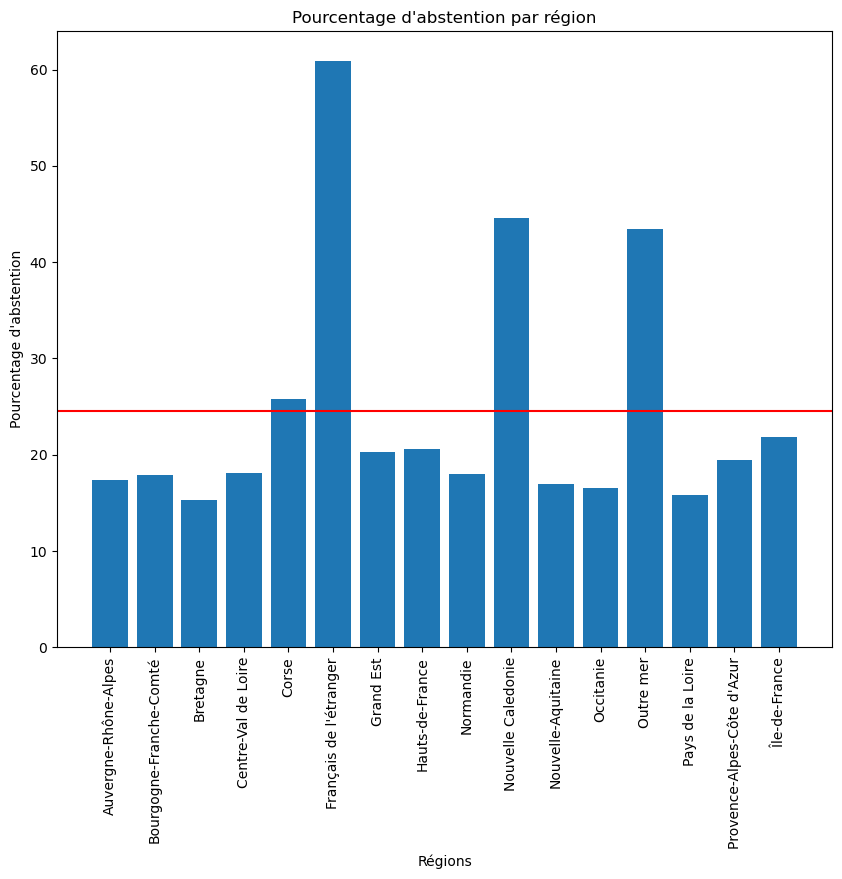

In [184]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(pcent_abstention_par_region["Région"], pcent_abstention_par_region["Pcentage d'abstentions"], label= '', color='tab:blue')
#ax.set_xticks(rotation='vertical')
moyenne_pcent_abstention = pcent_abstention_par_region["Pcentage d'abstentions"].mean()
plt.axhline(y=moyenne_pcent_abstention, color='r', linestyle='-')
plt.xticks(rotation=90)
plt.ylabel("Pourcentage d'abstention")
plt.xlabel("Régions")
plt.title("Pourcentage d'abstention par région")

In [185]:
pcent_choix_A = (referendum_dataset.groupby(by="Région")["Choix A"].sum()/(referendum_dataset.groupby(by="Région")["Inscrits"].sum() - referendum_dataset.groupby(by="Région")["Abstentions"].sum()))*100
pcent_choix_A = pd.DataFrame(pcent_choix_A)  
pcent_choix_A = pcent_choix_A.reset_index()
pcent_choix_A = pcent_choix_A.rename(columns={0:"Pcent choix A"})

pcent_choix_B = (referendum_dataset.groupby(by="Région")["Choix B"].sum()/(referendum_dataset.groupby(by="Région")["Inscrits"].sum() - referendum_dataset.groupby(by="Région")["Abstentions"].sum()))*100
pcent_choix_B = pd.DataFrame(pcent_choix_B)
pcent_choix_B=pcent_choix_B.reset_index()
pcent_choix_B = pcent_choix_B.rename(columns={0:"Pcent choix B"})

pcent_blancs_et_nuls = (referendum_dataset.groupby(by="Région")["Blancs et nuls"].sum()/(referendum_dataset.groupby(by="Région")["Inscrits"].sum() - referendum_dataset.groupby(by="Région")["Abstentions"].sum()))*100
pcent_blancs_et_nuls = pd.DataFrame(pcent_blancs_et_nuls)  
pcent_blancs_et_nuls = pcent_blancs_et_nuls.reset_index()
pcent_blancs_et_nuls = pcent_blancs_et_nuls.rename(columns={0:"Pcent nuls&blancs"})

df_choix_par_region = pd.merge(pcent_choix_A, pcent_choix_B, on="Région")
df_choix_par_region = pd.merge(df_choix_par_region, pcent_blancs_et_nuls, on = "Région")

In [186]:
df_choix_par_region

,Région,Pcent choix A,Pcent choix B,Pcent nuls&blancs
0,Auvergne-Rhône-Alpes,41.491723,56.613746,1.894531
1,Bourgogne-Franche-Comté,40.756549,57.189846,2.053606
2,Bretagne,46.830996,51.379355,1.789649
3,Centre-Val de Loire,40.065609,57.979761,1.954630
4,Corse,37.223271,60.991855,1.784874
5,Français de l'étranger,42.586288,56.332045,1.081667
6,Grand Est,35.418859,62.728317,1.852824
7,Hauts-de-France,42.204062,55.983647,1.812291
8,Normandie,41.966935,56.208802,1.824263
9,Nouvelle Caledonie,31.493648,65.920898,2.585454


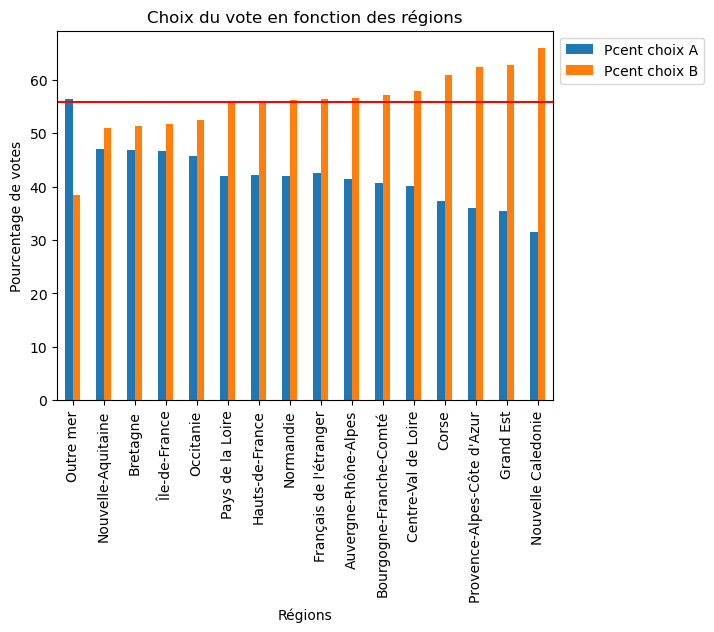

In [187]:
feature = ["Pcent choix A", "Pcent choix B"] #"Pcent nuls&blancs"
df_choix_par_region = df_choix_par_region.sort_values("Pcent choix B")
df_choix_par_region.plot(x='Région',y=feature, kind='bar')
moyenne_pcent_choix_A = df_choix_par_region["Pcent choix A"].mean()
moyenne_pcent_choix_B = df_choix_par_region["Pcent choix B"].mean()

plt.axhline(y=moyenne_pcent_choix_B, color='r', linestyle='-')
plt.legend(bbox_to_anchor = (1,1))

plt.xlabel("Régions")
plt.ylabel("Pourcentage de votes")
plt.title("Choix du vote en fonction des régions")
plt.show()

Concaténation des différents datasets
-

In [188]:
def supprime_accent(string):
        """ supprime les accents du texte source """

        accent = ['é', 'è', 'ê', 'à', 'ù', 'û', 'ç', 'ô', 'î', 'ï', 'â', "'", "-" ]
        sans_accent = ['e', 'e', 'e', 'a', 'u', 'u', 'c', 'o', 'i', 'i', 'a', " ", " "]
        for i in range(len(accent)):
            string = string.replace(accent[i], sans_accent[i])
        return string

In [189]:
for indice in referendum_dataset.index: 
    referendum_dataset["Libellé de la commune"][indice] = referendum_dataset["Libellé de la commune"][indice].lower()
    referendum_dataset["Libellé de la commune"][indice] = supprime_accent(referendum_dataset["Libellé de la commune"][indice])

In [190]:
referendum_dataset = referendum_dataset.set_index("Libellé de la commune")

In [191]:
df_pop_2013 = pd.read_excel("/Users/sebastienlouis/rnd-explo/SaintGobain/base-cc-evol-struct-pop-2013.xls", sheet_name="COM_2013")

In [192]:
df_pop_2013 = df_pop_2013.drop([0,1,2])
for elem in df_pop_2013.columns:
    df_pop_2013 = df_pop_2013.rename(columns={elem : df_pop_2013[elem][3]})
df_pop_2013 = df_pop_2013.drop(3)
df_pop_2013 = df_pop_2013.reset_index()
df_pop_2013 = df_pop_2013.drop("index", axis=1)
df_pop_2013 = df_pop_2013.drop(0)

In [193]:
for indice in df_pop_2013.index: 
    df_pop_2013["Libellé géographique"][indice] = df_pop_2013["Libellé géographique"][indice].lower()
    df_pop_2013["Libellé géographique"][indice] = supprime_accent(df_pop_2013["Libellé géographique"][indice])

In [194]:
df_pop_2013 = df_pop_2013.set_index("Libellé géographique")

In [195]:
#referendum_dataset = referendum_dataset[referendum_dataset.index.isin(df_pop_2013.index)]

In [196]:
#df_pop_2013 = df_pop_2013[df_pop_2013.index.isin(referendum_dataset.index)]

In [197]:
ref_data = referendum_dataset.groupby(["Libellé du département", "Code du département", "Région"]).sum()

In [198]:
ref_data=ref_data.rename(index={"1": "01", "2":"02", "3": "03", "4": "04", "5": "05", "6": "06", "7":"07", "8":"08", "9":"09", "ZA": "971", "ZB": "972", "ZC": "973", "ZD": "974"})

In [199]:
ref_data = ref_data.drop(["ZX","ZP","ZN", "ZS", "ZW", "ZM", "ZZ"], level=1)

In [200]:
#pop = df_pop_2013[df_pop_2013.index.isin(referendum_dataset.index)].groupby(["Département"]).sum()
pop = df_pop_2013.groupby(["Département"]).sum()
pop = pop.drop(["Code géographique", "Région", "Région 2016"], axis=1)

In [201]:
ref_data = ref_data.sort_values(by="Code du département")

In [202]:
df_merged = pd.merge(ref_data, pop, on=[ref_data.index.get_level_values(0),ref_data.index.get_level_values(1),ref_data.index.get_level_values(2)], how="right")

/var/folders/p7/4tnjxr1x2b70l9tfl0vw3wjc0000gp/T/ipykernel_9604/3594377114.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged = pd.merge(ref_data, pop, on=[ref_data.index.get_level_values(0),ref_data.index.get_level_values(1),ref_data.index.get_level_values(2)], how="right")
/var/folders/p7/4tnjxr1x2b70l9tfl0vw3wjc0000gp/T/ipykernel_9604/3594377114.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged = pd.merge(ref_data, pop, on=[ref_data.index.get_level_values(0),ref_data.index.get_level_values(1),ref_data.i

In [203]:
df_merged = df_merged.round()

In [204]:
df_merged

,key_0,key_1,key_2,Code de la commune,Inscrits,Abstentions,Blancs et nuls,Choix A,Choix B,Population en 2013 (princ),...,Pop 25-54 ans Autres en 2013 (compl),Pop 55 ans ou plus en 2013 (compl),Pop 55 ans ou plus Agriculteurs exploitants en 2013 (compl),"Pop 55 ans ou plus Artisans, Comm., Chefs entr. en 2013 (compl)","Pop 55 ans ou plus Cadres, Prof. intel. sup. en 2013 (compl)",Pop 55 ans ou plus Prof. intermédiaires en 2013 (compl),Pop 55 ans ou plus Employés en 2013 (compl),Pop 55 ans ou plus Ouvriers en 2013 (compl),Pop 55 ans ou plus Retraités en 2013 (compl),Pop 55 ans ou plus Autres en 2013 (compl)
0,AIN,01,Auvergne-Rhône-Alpes,96341,393808,65996,6453,116379,204980,619497.0,...,18726.0,173402.0,1010.0,3915.0,6586.0,9636.0,10251.0,8477.0,122911.0,10616.0
1,AISNE,02,Hauts-de-France,340904,376068,72928,5196,120916,177028,540067.0,...,24315.0,168065.0,1365.0,2676.0,3846.0,6231.0,9560.0,9179.0,121439.0,13767.0
2,ALLIER,03,Auvergne-Rhône-Alpes,51482,256275,45266,5059,96398,109552,343431.0,...,12498.0,134420.0,1595.0,2567.0,3168.0,4562.0,7456.0,4747.0,101941.0,8383.0
3,ALPES DE HAUTE PROVENCE,04,Provence-Alpes-Côte d'Azur,24873,123933,21034,2111,44634,56154,161916.0,...,5755.0,61403.0,584.0,1601.0,1843.0,2692.0,3394.0,1809.0,44818.0,4662.0
4,HAUTES ALPES,05,Provence-Alpes-Côte d'Azur,16484,106865,18246,1842,38210,48567,139279.0,...,4071.0,49035.0,519.0,1373.0,1526.0,2425.0,2735.0,1469.0,35377.0,3613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,VAL D'OISE,95,Île-de-France,61519,704810,162343,9752,254693,278022,1194681.0,...,49129.0,281291.0,297.0,5665.0,18243.0,20488.0,21731.0,13932.0,180583.0,20351.0
96,GUADELOUPE,971,Outre mer,3745,298108,141585,11364,95161,49998,402119.0,...,29185.0,110930.0,997.0,3790.0,3392.0,5667.0,9562.0,5399.0,69343.0,12782.0
97,MARTINIQUE,972,Outre mer,7395,302903,144126,12507,90063,56207,385551.0,...,23515.0,116586.0,748.0,3522.0,3528.0,5661.0,10242.0,6130.0,74096.0,12659.0
98,GUYANE,973,Outre mer,7164,76874,37706,1756,20425,16987,244118.0,...,33764.0,26700.0,246.0,1218.0,1582.0,1702.0,2480.0,2297.0,11309.0,5865.0


In [205]:
df_merged=df_merged[(df_merged.key_1 != "971") & (df_merged.key_1 != "974")& (df_merged.key_1 != "973")& (df_merged.key_1 != "972")]

In [206]:
df_merged

,key_0,key_1,key_2,Code de la commune,Inscrits,Abstentions,Blancs et nuls,Choix A,Choix B,Population en 2013 (princ),...,Pop 25-54 ans Autres en 2013 (compl),Pop 55 ans ou plus en 2013 (compl),Pop 55 ans ou plus Agriculteurs exploitants en 2013 (compl),"Pop 55 ans ou plus Artisans, Comm., Chefs entr. en 2013 (compl)","Pop 55 ans ou plus Cadres, Prof. intel. sup. en 2013 (compl)",Pop 55 ans ou plus Prof. intermédiaires en 2013 (compl),Pop 55 ans ou plus Employés en 2013 (compl),Pop 55 ans ou plus Ouvriers en 2013 (compl),Pop 55 ans ou plus Retraités en 2013 (compl),Pop 55 ans ou plus Autres en 2013 (compl)
0,AIN,01,Auvergne-Rhône-Alpes,96341,393808,65996,6453,116379,204980,619497.0,...,18726.0,173402.0,1010.0,3915.0,6586.0,9636.0,10251.0,8477.0,122911.0,10616.0
1,AISNE,02,Hauts-de-France,340904,376068,72928,5196,120916,177028,540067.0,...,24315.0,168065.0,1365.0,2676.0,3846.0,6231.0,9560.0,9179.0,121439.0,13767.0
2,ALLIER,03,Auvergne-Rhône-Alpes,51482,256275,45266,5059,96398,109552,343431.0,...,12498.0,134420.0,1595.0,2567.0,3168.0,4562.0,7456.0,4747.0,101941.0,8383.0
3,ALPES DE HAUTE PROVENCE,04,Provence-Alpes-Côte d'Azur,24873,123933,21034,2111,44634,56154,161916.0,...,5755.0,61403.0,584.0,1601.0,1843.0,2692.0,3394.0,1809.0,44818.0,4662.0
4,HAUTES ALPES,05,Provence-Alpes-Côte d'Azur,16484,106865,18246,1842,38210,48567,139279.0,...,4071.0,49035.0,519.0,1373.0,1526.0,2425.0,2735.0,1469.0,35377.0,3613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,ESSONNE,91,Île-de-France,68428,767292,159764,10277,276826,320425,1253931.0,...,44822.0,312026.0,267.0,5334.0,23061.0,22610.0,20881.0,11482.0,209472.0,18920.0
92,HAUTS DE SEINE,92,Île-de-France,1489,938538,193160,11726,324448,409204,1591403.0,...,52939.0,391488.0,69.0,9261.0,43325.0,27129.0,27005.0,11717.0,245404.0,27577.0
93,SEINE SAINT-DENIS,93,Île-de-France,1770,740536,196517,10104,316672,217243,1552482.0,...,95310.0,337722.0,23.0,7061.0,16329.0,21819.0,31076.0,24508.0,205754.0,31152.0
94,VAL DE MARNE,94,Île-de-France,2180,767571,172708,9501,297286,288076,1354005.0,...,55173.0,337379.0,30.0,7565.0,26556.0,24142.0,24924.0,13701.0,217544.0,22916.0


In [207]:
df_revenu_menage = pd.read_excel("/Users/sebastienlouis/rnd-explo/SaintGobain/filo-revenu-pauvrete-menage-2013.xls", sheet_name="COM")

In [208]:
df_revenu_menage = df_revenu_menage.drop([0,1,2])
for elem in df_revenu_menage.columns:
    df_revenu_menage = df_revenu_menage.rename(columns={elem : df_revenu_menage[elem][3]})
df_revenu_menage = df_revenu_menage.reset_index()
df_revenu_menage = df_revenu_menage.drop("index", axis=1)
df_revenu_menage = df_revenu_menage.drop(0)
df_revenu_menage = df_revenu_menage.drop(1)

In [209]:
for elem in df_revenu_menage.index: 
    df_revenu_menage["Code géographique"][elem] = df_revenu_menage["Code géographique"][elem][:2]


In [210]:
for indice in df_revenu_menage.index: 
    df_revenu_menage["Libellé géographique"][indice] = df_revenu_menage["Libellé géographique"][indice].lower()
    df_revenu_menage["Libellé géographique"][indice] = supprime_accent(df_revenu_menage["Libellé géographique"][indice])

df_revenu_grouped = df_revenu_menage.groupby("Code géographique").mean()

/var/folders/p7/4tnjxr1x2b70l9tfl0vw3wjc0000gp/T/ipykernel_9604/2850605946.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_revenu_grouped = df_revenu_menage.groupby("Code géographique").mean()


In [211]:
df_revenu_grouped.index.name = "Geographic code"

In [212]:
df_revenu_grouped

,Nombre de ménages fiscaux,Nombre de personnes dans les ménages fiscaux,Médiane du niveau vie,Part des ménages fiscaux imposés,Taux de pauvreté-Ensemble,Taux de pauvreté-moins de 30 ans,Taux de pauvreté-30 à 39 ans,Taux de pauvreté-40 à 49 ans,Taux de pauvreté-50 à 59 ans,Taux de pauvreté-60 à 74 ans,...,"Part des pensions, retraites et rentes",Part des revenus du patrimoine et autres revenus,Part de l'ensemble des prestations sociales,dont part des prestations familiales,dont part des minima sociaux,dont part des prestations logement,Part des impôts,Rapport inter-décile 9e décile/1er decile,1er décile du niveau de vie,9e décile du niveau de vie
Geographic code,,,,,,,,,,,,,,,,,,,,,
01,606.814356,1486.159653,22178.428381,61.138889,11.566038,25.666667,20.454545,18.294118,19.111111,16.400000,...,24.833803,10.471831,4.080282,2.246479,0.838028,0.995775,-16.209859,3.493461,12296.786662,40879.933708
02,312.601429,745.292143,19459.383775,47.636364,21.272727,41.800000,38.083333,33.866667,26.363636,13.142857,...,31.284848,8.618182,8.490909,3.139394,2.875758,2.466667,-13.987879,3.078168,9764.107802,29778.469127
03,502.525478,1060.813694,18669.437545,54.038462,13.695652,33.000000,24.666667,21.777778,18.750000,10.750000,...,37.415385,12.403846,5.473077,1.838462,2.084615,1.546154,-15.246154,2.959693,11309.455437,33289.448296
04,457.065359,991.637255,18465.636381,54.333333,14.866667,31.500000,23.333333,21.166667,16.666667,13.000000,...,34.666667,11.966667,5.220000,2.053333,1.606667,1.540000,-15.360000,3.162518,10817.843737,34069.473269
05,434.218310,943.816901,18897.661718,54.400000,13.600000,22.000000,16.500000,16.333333,14.333333,9.000000,...,34.220000,10.940000,5.250000,2.250000,1.530000,1.480000,-14.960000,2.920806,11076.171735,32296.308730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2504.492228,6486.292746,25307.403332,74.790000,10.413333,21.680000,17.812500,16.365854,15.466667,11.333333,...,23.642000,9.249000,3.789000,2.176000,0.804000,0.803000,-19.776000,3.087416,13498.485151,41169.535704
92,18712.138889,43604.986111,27780.293639,74.457143,11.057143,16.296296,11.406250,12.235294,12.121212,11.142857,...,20.637143,12.657143,3.482857,1.634286,0.920000,0.920000,-24.051429,4.443218,12340.004083,55339.606134
93,14172.100000,38910.425000,17972.776637,55.850000,25.375000,30.685714,29.394737,30.894737,26.162162,20.138889,...,20.320000,7.277500,8.910000,3.727500,2.667500,2.520000,-16.350000,3.698109,8935.561120,32738.739872


In [213]:
for elem in df_revenu_grouped.index:
    if elem == "78":
        print(df_revenu_grouped["9e décile du niveau de vie"][elem])

48564.968106040535


In [214]:
df_merged.set_index("key_1", inplace=True)

In [215]:
df_merged = df_merged.rename(columns = {"key_0": "departement"})

In [216]:
df_merged_2 = pd.merge(df_merged, df_revenu_grouped, on = df_merged.index)

In [217]:
df_diplome = pd.read_excel("/Users/sebastienlouis/rnd-explo/SaintGobain/pop-16ans-dipl6819_v2.xls", sheet_name="DEP_2008")

In [218]:
df_diplome = df_diplome.drop([0,1,2,3,4,5,6,7,8,9,10,11])
for elem in df_diplome.columns:
    df_diplome = df_diplome.rename(columns={elem : df_diplome[elem][12]})
df_diplome = df_diplome.drop([12,13])
df_diplome = df_diplome.drop([110,111,112,113])

# for indice in df_diplome.index: 
#     df_diplome["Libellé de commune"][indice] = df_revenu_menage["Libellé géographique"][indice].lower()
#     df_diplome["Libellé de commune"][indice] = supprime_accent(df_revenu_menage["Libellé géographique"][indice])

In [219]:
df_diplome.set_index("Département")

,Région,Libellé de\ndépartement,Aucun diplôme\nHommes\n16 à 24 ans\nRP2008,Aucun diplôme\nHommes\n25 ans ou plus\nRP2008,Aucun diplôme\nFemmes\n16 à 24 ans\nRP2008,Aucun diplôme\nFemmes\n25 ans ou plus\nRP2008,Diplôme de niveau CEP\nHommes\n16 à 24 ans\nRP2008,Diplôme de niveau CEP\nHommes\n25 ans ou plus\nRP2008,Diplôme de niveau CEP\nFemmes\n16 à 24 ans\nRP2008,Diplôme de niveau CEP\nFemmes\n25 ans ou plus\nRP2008,...,Diplôme de niveau bac général ou technique\nFemmes\n16 à 24 ans\nRP2008,Diplôme de niveau bac général ou technique\nFemmes\n25 ans ou plus\nRP2008,Diplôme universitaire de 1er cycle Hommes\n16 à 24 ans\nRP2008,Diplôme universitaire de 1er cycle Hommes\n25 ans ou plus\nRP2008,Diplôme universitaire de 1er cycle Femmes\n16 à 24 ans\nRP2008,Diplôme universitaire de 1er cycle Femmes\n25 ans ou plus\nRP2008,Diplôme universitaire de 2ème ou 3ème cycle Hommes\n16 à 24 ans\nRP2008,Diplôme universitaire de 2ème ou 3ème cycle Hommes\n25 ans ou plus\nRP2008,Diplôme universitaire de 2ème ou 3ème cycle Femmes\n16 à 24 ans\nRP2008,Diplôme universitaire de 2ème ou 3ème cycle Femmes\n25 ans ou plus\nRP2008
Département,,,,,,,,,,,,,,,,,,,,,
01,84,Ain,3481.092654,32787.101133,2139.538861,36329.605751,144.678391,18690.000723,86.515887,30980.318858,...,4402.907886,32468.693666,1984.321586,19695.112568,2296.259327,27353.511287,676.983923,22105.83086,978.463653,20585.117776
02,32,Aisne,4719.659308,40102.337405,2816.049152,49450.730439,192.145003,22024.425002,83.22292,36166.023828,...,3579.162562,25252.586137,1229.898963,13315.47297,2051.505001,19063.501387,541.856373,11400.375551,764.148292,11153.022497
03,84,Allier,1874.055785,20387.457426,1029.076753,24005.824118,62.702941,17026.408296,49.280068,29241.587589,...,2189.777782,19061.26145,813.881812,9576.060541,1176.038922,13655.788263,245.400578,9010.372107,375.78259,8632.012048
04,93,Alpes-de-Haute-Provence,856.399831,9029.27079,569.957665,10631.231823,37.23902,5665.521591,35.759469,8413.003947,...,972.439336,10140.917813,414.94689,5158.357094,534.883064,7519.677359,116.469462,6136.50386,178.214218,5888.171261
05,93,Hautes-Alpes,619.638656,6626.15355,367.304764,7183.628357,18.555275,5035.208638,23.113081,7049.103563,...,985.702127,9027.993025,337.155157,4891.754164,564.297451,8219.303454,112.664058,5293.269031,146.001852,5465.812414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,11,Essonne,8065.854092,61730.125196,4590.357034,65916.334676,317.554368,27403.132526,199.67772,43873.920086,...,10367.914129,71782.477599,4519.655733,46793.272478,6056.465303,63628.26821,2956.080646,70831.244333,3696.16598,58936.229278
92,11,Hauts-de-Seine,6689.994508,69069.739161,4443.771468,81351.489762,243.58823,24463.355681,182.77497,42852.69649,...,11186.730742,93673.054371,5061.057912,54819.386889,7384.311705,85787.073303,6504.583014,179355.811451,8212.236584,157475.557753
93,11,Seine-Saint-Denis,14345.502313,139144.779438,9583.337722,143535.586087,515.752103,33148.341055,435.309412,51020.139037,...,14498.523649,78249.932888,4732.053758,39955.795902,6812.92145,53645.600492,2914.700034,55467.245348,4668.226284,53155.232151


In [220]:
df_merged_2 = df_merged_2.set_index("key_0")

In [221]:
df_merged_2 = df_merged_2.rename(columns = {"key_0": "num departement"})

In [222]:
df_merged_3 = pd.merge(df_merged_2, df_diplome, on = df_merged_2.index)

In [223]:
df_merged_3 = df_merged_3.rename(columns = {"key_0":"Numéro de département", "departement" : "Département", "key_2": "Région"})

In [224]:
df_merged_3

,Numéro de département,Département,Région,Code de la commune,Inscrits,Abstentions,Blancs et nuls,Choix A,Choix B,Population en 2013 (princ),...,Diplôme de niveau bac général ou technique\nFemmes\n16 à 24 ans\nRP2008,Diplôme de niveau bac général ou technique\nFemmes\n25 ans ou plus\nRP2008,Diplôme universitaire de 1er cycle Hommes\n16 à 24 ans\nRP2008,Diplôme universitaire de 1er cycle Hommes\n25 ans ou plus\nRP2008,Diplôme universitaire de 1er cycle Femmes\n16 à 24 ans\nRP2008,Diplôme universitaire de 1er cycle Femmes\n25 ans ou plus\nRP2008,Diplôme universitaire de 2ème ou 3ème cycle Hommes\n16 à 24 ans\nRP2008,Diplôme universitaire de 2ème ou 3ème cycle Hommes\n25 ans ou plus\nRP2008,Diplôme universitaire de 2ème ou 3ème cycle Femmes\n16 à 24 ans\nRP2008,Diplôme universitaire de 2ème ou 3ème cycle Femmes\n25 ans ou plus\nRP2008
0,01,AIN,Auvergne-Rhône-Alpes,96341,393808,65996,6453,116379,204980,619497.0,...,4402.907886,32468.693666,1984.321586,19695.112568,2296.259327,27353.511287,676.983923,22105.83086,978.463653,20585.117776
1,02,AISNE,Hauts-de-France,340904,376068,72928,5196,120916,177028,540067.0,...,3579.162562,25252.586137,1229.898963,13315.47297,2051.505001,19063.501387,541.856373,11400.375551,764.148292,11153.022497
2,03,ALLIER,Auvergne-Rhône-Alpes,51482,256275,45266,5059,96398,109552,343431.0,...,2189.777782,19061.26145,813.881812,9576.060541,1176.038922,13655.788263,245.400578,9010.372107,375.78259,8632.012048
3,04,ALPES DE HAUTE PROVENCE,Provence-Alpes-Côte d'Azur,24873,123933,21034,2111,44634,56154,161916.0,...,972.439336,10140.917813,414.94689,5158.357094,534.883064,7519.677359,116.469462,6136.50386,178.214218,5888.171261
4,05,HAUTES ALPES,Provence-Alpes-Côte d'Azur,16484,106865,18246,1842,38210,48567,139279.0,...,985.702127,9027.993025,337.155157,4891.754164,564.297451,8219.303454,112.664058,5293.269031,146.001852,5465.812414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,ESSONNE,Île-de-France,68428,767292,159764,10277,276826,320425,1253931.0,...,10367.914129,71782.477599,4519.655733,46793.272478,6056.465303,63628.26821,2956.080646,70831.244333,3696.16598,58936.229278
92,92,HAUTS DE SEINE,Île-de-France,1489,938538,193160,11726,324448,409204,1591403.0,...,11186.730742,93673.054371,5061.057912,54819.386889,7384.311705,85787.073303,6504.583014,179355.811451,8212.236584,157475.557753
93,93,SEINE SAINT-DENIS,Île-de-France,1770,740536,196517,10104,316672,217243,1552482.0,...,14498.523649,78249.932888,4732.053758,39955.795902,6812.92145,53645.600492,2914.700034,55467.245348,4668.226284,53155.232151
94,94,VAL DE MARNE,Île-de-France,2180,767571,172708,9501,297286,288076,1354005.0,...,11712.693299,80199.956614,4567.397651,47055.090919,6442.750562,66453.144619,3764.277401,89490.343687,5155.791212,85244.193119


In [225]:
df_merged_3["pcent femmes"] = df_merged_3["Pop Femmes en 2013 (princ)"]/(df_merged_3["Pop Femmes en 2013 (princ)"]+df_merged_3["Pop Hommes en 2013 (princ)"])
df_merged_3["pcent hommes"] = 1-df_merged_3["pcent femmes"]
df_merged_3["pcent 15-29 ans"] = df_merged_3["Pop 15-29 ans en 2013 (princ)"]/df_merged_3["Population en 2013 (princ)"]*100
df_merged_3["pcent 30-44 ans"] = df_merged_3["Pop 30-44 ans en 2013 (princ)"]/df_merged_3["Population en 2013 (princ)"]*100
df_merged_3["pcent 45-59 ans"] = df_merged_3["Pop 45-59 ans en 2013 (princ)"]/df_merged_3["Population en 2013 (princ)"]*100
df_merged_3["pcent 60-74 ans"] = df_merged_3["Pop 60-74 ans en 2013 (princ)"]/df_merged_3["Population en 2013 (princ)"]*100
df_merged_3["pcent 75-89 ans"] = df_merged_3["Pop 75-89 ans en 2013 (princ)"]/df_merged_3["Population en 2013 (princ)"]*100

df_merged_3["pcent cadres"] = df_merged_3["Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2013 (compl)"]/df_merged_3["Pop 15 ans ou plus en 2013 (compl)"]*100
df_merged_3["pcent agri"] = df_merged_3["Pop 15 ans ou plus Agriculteurs exploitants en 2013 (compl)"]/df_merged_3["Pop 15 ans ou plus en 2013 (compl)"]*100
df_merged_3["pcent artisants"] = df_merged_3["Pop 15 ans ou plus Artisans, Comm., Chefs entr. en 2013 (compl)"]/df_merged_3["Pop 15 ans ou plus en 2013 (compl)"]*100
df_merged_3["pcent ouvriers"] = df_merged_3["Pop 15 ans ou plus Ouvriers en 2013 (compl)"]/df_merged_3["Pop 15 ans ou plus en 2013 (compl)"]*100
df_merged_3["pcent retraités"] = df_merged_3["Pop 15 ans ou plus Retraités  en 2013 (compl)"]/df_merged_3["Pop 15 ans ou plus en 2013 (compl)"]*100




In [226]:
df_merged_3["pcent choix A"] = df_merged_3["Choix A"]/(df_merged_3["Inscrits"])*100
df_merged_3["pcent abstentions"] = df_merged_3["Abstentions"]/df_merged_3["Inscrits"]*100

In [227]:
df_merged_3["pct H sans diplome > 25 ans"] = df_merged_3['Aucun diplôme\nHommes\n25 ans ou plus\nRP2008']/df_merged_3["Pop Hommes en 2013 (princ)"]*100
df_merged_3["pct F sans diplome > 25 ans"] = df_merged_3['Aucun diplôme\nFemmes\n25 ans ou plus\nRP2008']/df_merged_3["Pop Femmes en 2013 (princ)"]*100

/var/folders/p7/4tnjxr1x2b70l9tfl0vw3wjc0000gp/T/ipykernel_9604/3818177493.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = test.corr()
/var/folders/p7/4tnjxr1x2b70l9tfl0vw3wjc0000gp/T/ipykernel_9604/3818177493.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<AxesSubplot: >

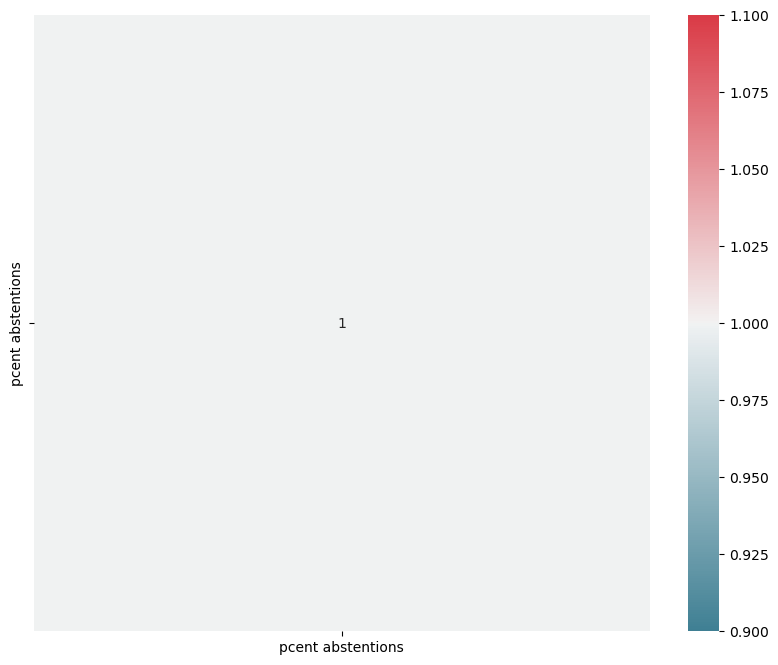

In [228]:
bug = df_merged_3[['Aucun diplôme\nFemmes\n25 ans ou plus\nRP2008',"pcent abstentions"]] 
test = bug
f, ax = plt.subplots(figsize=(10, 8))
corr = test.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [229]:
df_merged_3.columns.values

array(['Numéro de département', 'Département', 'Région',
       'Code de la commune', 'Inscrits', 'Abstentions', 'Blancs et nuls',
       'Choix A', 'Choix B', 'Population en 2013 (princ)',
       'Pop 0-14 ans en 2013 (princ)', 'Pop 15-29 ans en 2013 (princ)',
       'Pop 30-44 ans en 2013 (princ)', 'Pop 45-59 ans en 2013 (princ)',
       'Pop 60-74 ans en 2013 (princ)', 'Pop 75-89 ans en 2013 (princ)',
       'Pop 90 ans ou plus en 2013 (princ)', 'Pop Hommes en 2013 (princ)',
       'Pop Hommes 0-14 ans en 2013 (princ)',
       'Pop Hommes 15-29 ans en 2013 (princ)',
       'Pop Hommes 30-44 ans en 2013 (princ)',
       'Pop Hommes 45-59 ans en 2013 (princ)',
       'Pop Hommes 60-74 ans en 2013 (princ)',
       'Pop Hommes 75-89 ans en 2013 (princ)',
       'Pop Hommes 90 ans ou plus en 2013 (princ)',
       'Pop Hommes 0-19 ans en 2013  (princ)',
       'Pop Hommes 20-64 ans en 2013 (princ)',
       'Pop Hommes 65 ans ou plus en 2013 (princ)',
       'Pop Femmes en 2013 (princ)',
 

In [252]:
df_test = df_merged_3[["pcent choix A", "pcent abstentions", "Département", "Médiane du niveau vie",  "pcent femmes", "pcent hommes","pcent 15-29 ans", "pcent 30-44 ans", "pcent 45-59 ans", "pcent 60-74 ans", "Région", "pcent 75-89 ans", "pcent cadres", "pcent agri", "pcent artisants", "pcent ouvriers", "pcent retraités","pct H sans diplome > 25 ans", 'Population en 2013 (princ)', "pct F sans diplome > 25 ans", "Taux de pauvreté-Ensemble"]]

In [231]:
df_test

,pcent choix A,pcent abstentions,Département,Département,Médiane du niveau vie,pcent femmes,pcent hommes,pcent 15-29 ans,pcent 30-44 ans,pcent 45-59 ans,...,pcent 75-89 ans,pcent cadres,pcent agri,pcent artisants,pcent ouvriers,pcent retraités,pct H sans diplome > 25 ans,Population en 2013 (princ),pct F sans diplome > 25 ans,Taux de pauvreté-Ensemble
0,29.552218,16.758420,AIN,01,22178.428381,0.505599,0.494401,16.536803,20.830287,20.516484,...,6.927717,8.527427,0.750148,3.840983,16.058511,25.052778,10.704944,619497.0,11.598861,11.566038
1,32.152696,19.392238,AISNE,02,19459.383775,0.513162,0.486838,16.962895,18.730269,20.581520,...,8.283602,4.465314,1.085530,2.826791,17.852062,28.131845,15.252387,540067.0,17.843102,21.272727
2,37.615062,17.663057,ALLIER,03,18669.437545,0.520879,0.479121,14.254101,17.027001,20.913954,...,11.774126,4.344095,1.852512,3.489808,14.028435,35.427126,12.390202,343431.0,13.419622,13.695652
3,36.014621,16.972074,ALPES DE HAUTE PROVENCE,04,18465.636381,0.514878,0.485122,14.123990,17.206453,21.462363,...,10.358457,5.533559,1.628821,5.119151,11.340435,33.329886,11.495081,161916.0,12.752326,14.866667
4,35.755392,17.073878,HAUTES ALPES,05,18897.661718,0.511577,0.488423,14.483160,18.552689,21.361440,...,9.588667,5.244731,1.608952,5.366358,11.216618,31.017497,9.740476,139279.0,10.082002,13.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,36.078312,20.821799,ESSONNE,91,25307.403332,0.510131,0.489869,19.430654,20.859920,19.816800,...,5.918747,13.447676,0.081183,2.671080,10.486151,21.281203,10.049478,1253931.0,10.304757,10.413333
92,34.569511,20.580946,HAUTS DE SEINE,92,27780.293639,0.523132,0.476868,19.441084,23.227617,18.695956,...,6.443308,24.250380,0.013116,3.058436,5.994070,19.280265,9.101428,1591403.0,9.771786,11.057143
93,42.762540,26.537130,SEINE SAINT-DENIS,93,17972.776637,0.508171,0.491829,20.667164,22.152463,18.703921,...,4.910073,8.347439,0.009723,2.993581,14.318230,17.264444,18.223258,1552482.0,18.193796,25.375000
94,38.730749,22.500590,VAL DE MARNE,94,23084.970289,0.519020,0.480980,19.983530,21.814690,19.460416,...,6.300789,14.985817,0.009746,3.087454,9.301256,20.154193,11.962944,1354005.0,12.068916,14.272727


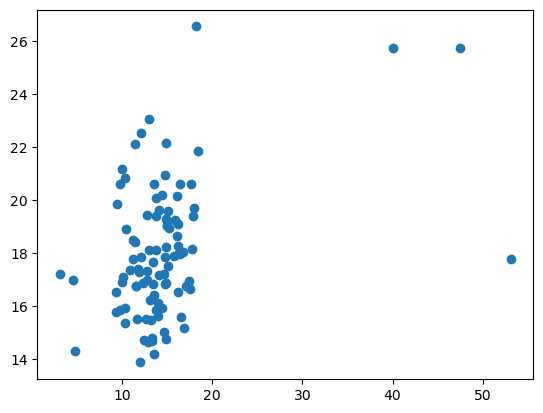

In [232]:
plt.scatter(df_test["pct F sans diplome > 25 ans"],df_test["pcent abstentions"])

/var/folders/p7/4tnjxr1x2b70l9tfl0vw3wjc0000gp/T/ipykernel_9604/1042275196.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = test.corr()
/var/folders/p7/4tnjxr1x2b70l9tfl0vw3wjc0000gp/T/ipykernel_9604/1042275196.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<AxesSubplot: >

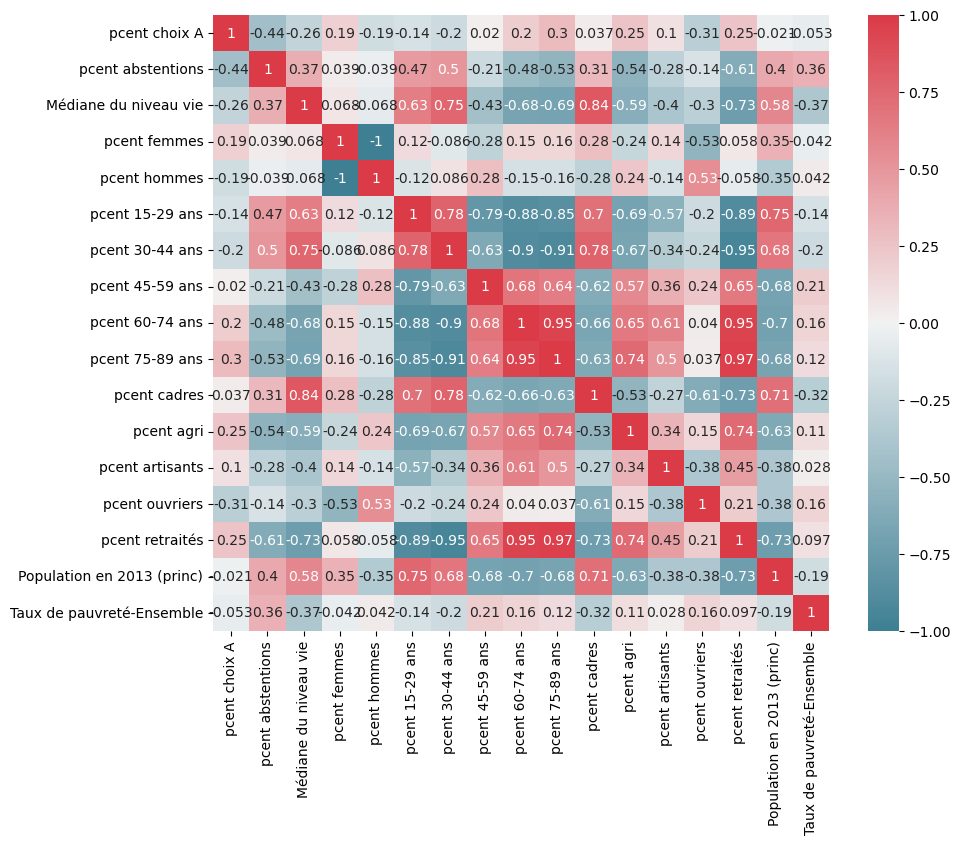

In [233]:
test = df_test
f, ax = plt.subplots(figsize=(10, 8))
corr = test.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

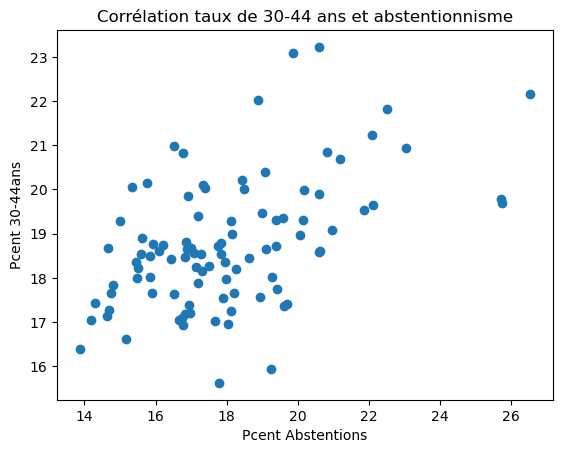

In [234]:
plt.scatter(df_merged_3["pcent abstentions"],df_merged_3["pcent 30-44 ans"])
plt.xlabel("Pcent Abstentions")
plt.ylabel("Pcent 30-44ans")
plt.title("Corrélation taux de 30-44 ans et abstentionnisme")
plt.show()

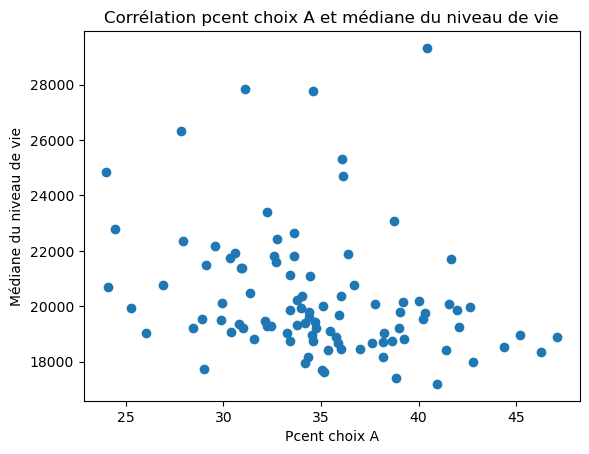

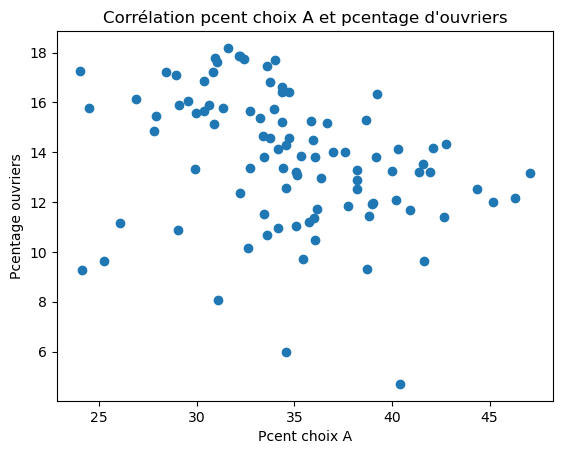

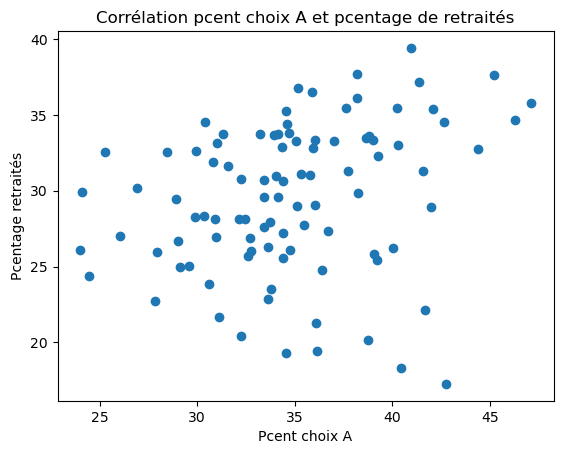

Text(0.5, 1.0, "Corrélation pcent choix A et pcentage d'agriculteurs")

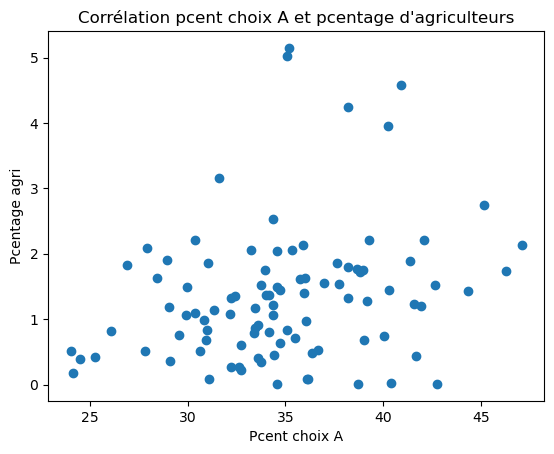

In [235]:
plt.scatter(df_merged_3["pcent choix A"],df_merged_3["Médiane du niveau vie"])
plt.xlabel("Pcent choix A")
plt.ylabel("Médiane du niveau de vie")
plt.title("Corrélation pcent choix A et médiane du niveau de vie")
plt.show()

plt.scatter(df_merged_3["pcent choix A"],df_merged_3["pcent ouvriers"])
plt.xlabel("Pcent choix A")
plt.ylabel("Pcentage ouvriers")
plt.title("Corrélation pcent choix A et pcentage d'ouvriers")
plt.show()

plt.scatter(df_merged_3["pcent choix A"],df_merged_3["pcent retraités"])
plt.xlabel("Pcent choix A")
plt.ylabel("Pcentage retraités")
plt.title("Corrélation pcent choix A et pcentage de retraités")
plt.show()

plt.scatter(df_merged_3["pcent choix A"],df_merged_3["pcent agri"])
plt.xlabel("Pcent choix A")
plt.ylabel("Pcentage agri")
plt.title("Corrélation pcent choix A et pcentage d'agriculteurs")

Modèles de prédictions
-

In [275]:
df_merged_3["pcent abstentions"].mean()

18.02435817737653

In [285]:
from sklearn.decomposition import PCA

In [306]:
df_pca = df_merged_3[["pcent femmes", "pcent hommes","pcent 15-29 ans", "pcent 30-44 ans", "pcent 45-59 ans", "pcent 60-74 ans", "pcent 75-89 ans", "pcent cadres", "pcent agri", "pcent artisants", "pcent ouvriers", "pcent retraités",'Population en 2013 (princ)', "Taux de pauvreté-Ensemble"]]

In [307]:
df_pca_target = df_merged_3["pcent abstentions"]

In [312]:
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(df_pca)
principalDf = pd.DataFrame(data=principalComponents,columns=['column 1', 'column 2'])

In [313]:
finalDf = pd.concat([principalDf, df_pca_target], axis=1)

In [314]:
finalDf

,column 1,column 2,pcent abstentions
0,-44022.427026,-6.306287,16.758420
1,-123452.427090,-1.718073,19.392238
2,-320088.427148,4.629597,17.663057
3,-501603.427110,0.598134,16.972074
4,-524240.427082,-2.402732,17.073878
...,...,...,...
91,590411.573021,-5.908083,20.821799
92,927883.573088,-8.380515,20.580946
93,888962.572995,-4.550147,26.537130
94,690485.573033,-6.401848,22.500590


In [279]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [253]:
df_test = df_merged_3[["pcent choix A", "pcent abstentions", "Département", "Médiane du niveau vie",  "pcent femmes", "pcent hommes","pcent 15-29 ans", "pcent 30-44 ans", "pcent 45-59 ans", "pcent 60-74 ans", "Région", "pcent 75-89 ans", "pcent cadres", "pcent agri", "pcent artisants", "pcent ouvriers", "pcent retraités","pct H sans diplome > 25 ans", 'Population en 2013 (princ)', "pct F sans diplome > 25 ans", "Taux de pauvreté-Ensemble"]]

In [276]:
#df_regression = df_test[["pcent abstentions",  "Médiane du niveau vie", "pcent 15-29 ans", "pcent 30-44 ans", "pcent 60-74 ans", "pcent 75-89 ans", "pcent agri", "pcent retraités", "Population en 2013 (princ)"]]
df_regression = df_test[["pcent abstentions", "pcent 15-29 ans", "pcent 30-44 ans","pcent retraités"]]

In [277]:
def linear_regression_model_abstentions(df):
    X = df.loc[:, df.columns != "pcent abstentions"]
    Y = df["pcent abstentions"]

    x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)


    reg_multiple = LinearRegression()
    reg_multiple.fit(x_train, y_train)
    y_prediction = reg_multiple.predict(x_test)
    plt.scatter(y_test, y_prediction)
    xx = np.array([0,max(y_test)])
    plt.plot(xx,xx)
    plt.xlabel("Pcent abstentions vrai échantillon")
    plt.ylabel("Prédiction pcent abstentions")
    plt.title("Prédiction du taux d'abstentions")
    plt.show()
    
    dic_results = {}


    dic_metrics = {}
    dic_metrics["RMSE"] = np.sqrt(mean_squared_error(y_test, y_prediction))
    dic_metrics["Mean error"] = mean_absolute_error(y_test, y_prediction)
    dic_metrics["Score"] = reg_multiple.score(x_test, y_test)
    dic_results["test_set"] = dic_metrics

    y_prediction = reg_multiple.predict(x_train)
    plt.scatter(y_train, y_prediction)
    xx = np.array([0,max(y_train)])
    plt.plot(xx,xx)
    plt.xlabel("Pcent abstentions vrai échantillon")
    plt.ylabel("Prédiction pcent abstentions")
    plt.title("Prédiction du taux d'abstentions")
    plt.show()

    dic_metrics = {}
    dic_metrics["RMSE"] = np.sqrt(mean_squared_error(y_train, y_prediction))
    dic_metrics["Mean error"] = mean_absolute_error(y_train, y_prediction)
    dic_metrics["Score"] = reg_multiple.score(x_train, y_train)
    dic_results["train_set"] = dic_metrics

    return dic_results


In [280]:
def lasso_model_abstentions(df):
    X = df.loc[:, df.columns != "pcent abstentions"]
    Y = df["pcent abstentions"]

    x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)


    reg_multiple = Lasso(alpha=0.1)
    reg_multiple.fit(x_train, y_train)
    y_prediction = reg_multiple.predict(x_test)
    plt.scatter(y_test, y_prediction)
    xx = np.array([0,max(y_test)])
    plt.plot(xx,xx)
    plt.xlabel("Pcent abstentions vrai échantillon")
    plt.ylabel("Prédiction pcent abstentions")
    plt.title("Prédiction du taux d'abstentions")
    plt.show()
    
    dic_results = {}


    dic_metrics = {}
    dic_metrics["RMSE"] = np.sqrt(mean_squared_error(y_test, y_prediction))
    dic_metrics["Mean error"] = mean_absolute_error(y_test, y_prediction)
    dic_metrics["Score"] = reg_multiple.score(x_test, y_test)
    dic_results["test_set"] = dic_metrics

    y_prediction = reg_multiple.predict(x_train)
    plt.scatter(y_train, y_prediction)
    xx = np.array([0,max(y_train)])
    plt.plot(xx,xx)
    plt.xlabel("Pcent abstentions vrai échantillon")
    plt.ylabel("Prédiction pcent abstentions")
    plt.title("Prédiction du taux d'abstentions")
    plt.show()

    dic_metrics = {}
    dic_metrics["RMSE"] = np.sqrt(mean_squared_error(y_train, y_prediction))
    dic_metrics["Mean error"] = mean_absolute_error(y_train, y_prediction)
    dic_metrics["Score"] = reg_multiple.score(x_train, y_train)
    dic_results["train_set"] = dic_metrics

    return dic_results

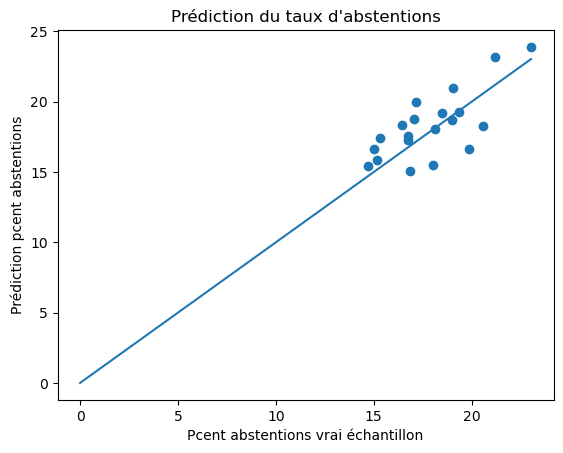

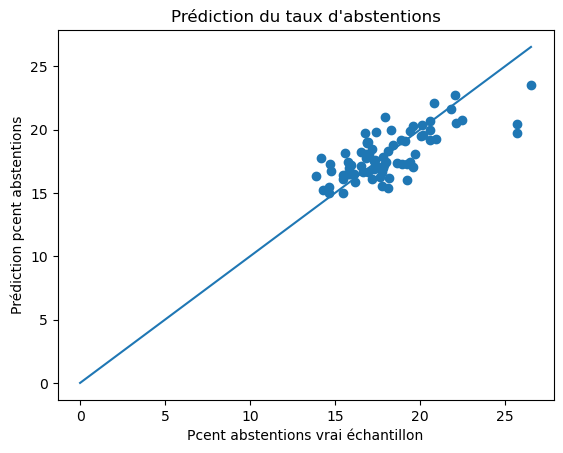

{'test_set': {'RMSE': 1.7009238901090085,
  'Mean error': 1.437414554082427,
  'Score': 0.37863710992365507},
 'train_set': {'RMSE': 1.7639131880316445,
  'Mean error': 1.3538214118281306,
  'Score': 0.5259754729708729}}

In [278]:
linear_regression_model_abstentions(df_regression)

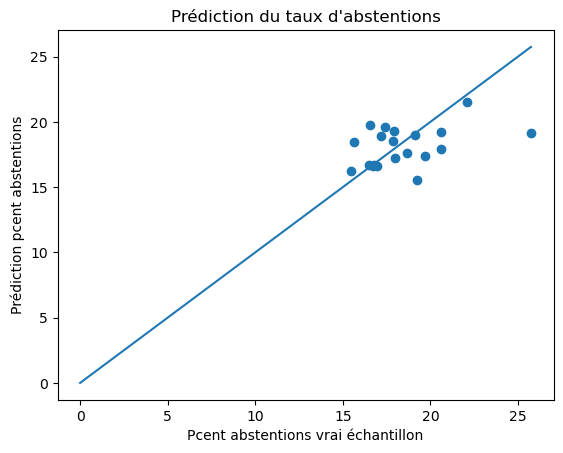

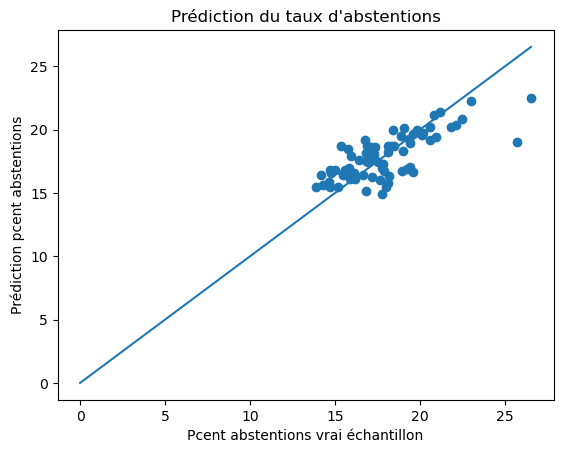

{'test_set': {'RMSE': 2.2688791075044685,
  'Mean error': 1.6274247779959787,
  'Score': 0.09681863735867957},
 'train_set': {'RMSE': 1.6694489055493007,
  'Mean error': 1.2873570086909463,
  'Score': 0.5533512807664589}}

In [282]:
lasso_model_abstentions(df_regression)

In [240]:
df_regression_choix_A = df_test[["pcent choix A",  "pcent 75-89 ans", "pcent hommes", "pcent femmes", "pcent agri", "pcent ouvriers", "pcent agri", "pcent retraités", "pcent 60-74 ans", "pcent 30-44 ans"]]

In [241]:
def linear_regression_model_choix_A(df):
    X = df.loc[:, df.columns != "pcent choix A"]
    Y = df["pcent choix A"]

    x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)


    reg_multiple = LinearRegression()
    reg_multiple.fit(x_train, y_train)
    y_prediction = reg_multiple.predict(x_test)
    plt.scatter(y_test, y_prediction)
    xx = np.array([0,max(y_test)])
    plt.plot(xx,xx)
    plt.xlabel("Pcent choix A vrai échantillon")
    plt.ylabel("Prédiction pcent choix A")
    plt.title("Prédiction du pcentage de choix A")
    plt.show()
    
    dic_metrics = {}
    dic_metrics["RMSE"] = np.sqrt(mean_squared_error(y_test, y_prediction))
    dic_metrics["Mean error"] = mean_absolute_error(y_test, y_prediction)
    dic_metrics["Score"] = reg_multiple.score(x_test, y_test)

    return dic_metrics

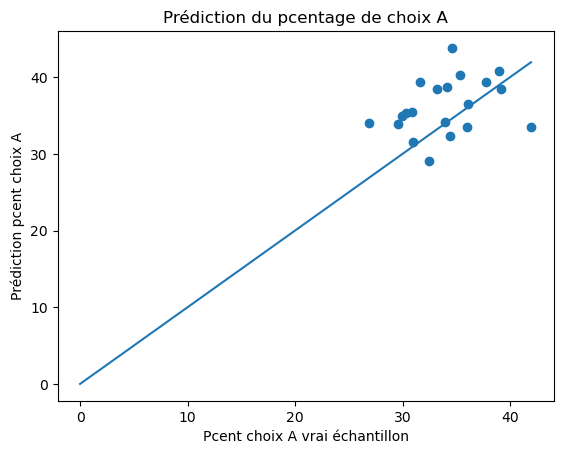

{'RMSE': 4.776291893981228,
 'Mean error': 3.957347594459749,
 'Score': -0.7064501797616682}

In [242]:
linear_regression_model_choix_A(df_regression_choix_A)

Exploration
-

In [243]:
from sklearn.cluster import KMeans

In [244]:
model = KMeans(n_clusters=5, n_init=10,max_iter=200)


In [245]:
y_predicted = model.fit_predict(df_merged_3[["pcent abstentions","Médiane du niveau vie"]])

In [246]:
y_predicted

array([2, 0, 4, 4, 4, 0, 4, 0, 4, 0, 4, 4, 2, 0, 4, 4, 4, 0, 4, 2, 0, 4,
       4, 2, 0, 2, 2, 0, 4, 4, 4, 2, 0, 0, 4, 0, 4, 0, 2, 0, 0, 0, 0, 4,
       0, 2, 4, 4, 4, 0, 4, 2, 0, 4, 2, 0, 0, 2, 4, 0, 2, 4, 0, 0, 0, 0,
       4, 2, 1, 2, 0, 0, 0, 2, 1, 3, 0, 2, 3, 4, 0, 0, 4, 0, 0, 0, 4, 4,
       0, 0, 2, 1, 3, 4, 2, 1], dtype=int32)

In [247]:
df_cluster = df_merged_3.copy()

In [248]:
df_cluster["Cluster médiane"] = y_predicted

<AxesSubplot: xlabel='Médiane du niveau vie', ylabel='pcent abstentions'>

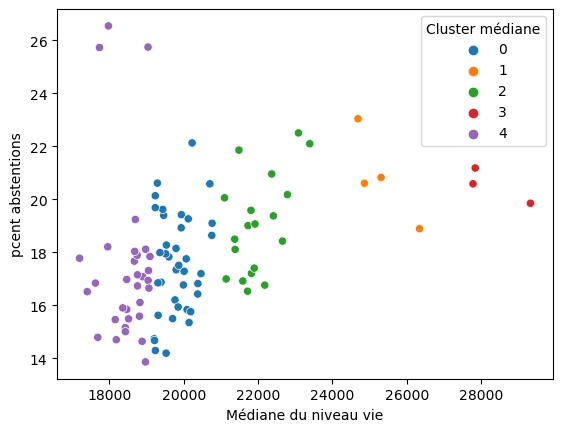

In [249]:
sns.scatterplot(data=df_cluster, x='Médiane du niveau vie', y='pcent abstentions', hue='Cluster médiane', palette="tab10")